In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import astropy.io.fits as fits

import glob

# Holy shit it worked.

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass 
# Well, it kind of worked. For some reason have to do it this way, with two lines instead of one, or it returns
# a "ModuleNotFoundError - No module named lsst.utils", or something to that effect.

import os

In [2]:
# Grab the current directory
cwd = os.getcwd()
# just one dir to start
directory = os.path.join(cwd, 'ckm05')
filepath = glob.glob(os.path.join(directory,'*.fits'))

In [3]:
# 
hdul = fits.open(filepath[-11])
# The header says what the 
header = hdul[0].header.copy()
spec_table = hdul[1].data.copy()
hdul.close()

In [4]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
DATE    = '2007-01-09T16:25:07' / Date FITS file was generated                  
IRAF-TLM= '11:25:19 (09/01/2007)' / Time of last modification                   
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'STScI-STSDAS/TABLES' / Tables version 2002-02-22                     
FILENAME= 'ckm05_7250.fits'    / name of file                                   
NEXTEND =                    1 / number of extensions in file                   
TEFF    =                 7250                                                  
LOG_Z   =                 -0

(1000, 10000)

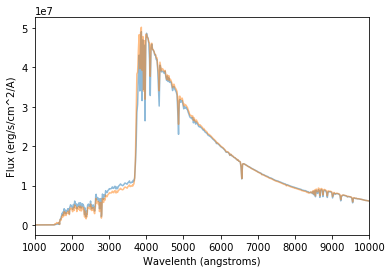

In [5]:
# Let's see what a few of them look like
plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=0.5)
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=.5)
# Always always keep track of units!
plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000])

In [6]:
# OK, those look like stellar spectra I can believe in.

In [7]:
# Had to comment out the os functions and import the filters using my specific directory stuff.
# Python couldn't find LSST_THROUGHPUTS_BASELINE and this was just the quickest way to troubleshoot.



In [8]:
# LSST standard is nm rather than Ang. I think I did this right.
my_sed = Sed(wavelen=spec_table['WAVELENGTH']/10., flambda=spec_table['g15']*10)

In [9]:
# now to read in an LSST bandpass
try:
    band_dir = os.getenv("LSST_THROUGHPUTS_BASELINE")
except:
    band_dir = '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/throughputs/2017.01.31-6-g29ce4f5/baseline/'

filterlist =['u', 'g', 'r', 'i', 'z', 'y']
bps = []

for filtername in filterlist:
    
    tempB = Bandpass()
    tempB.readThroughput(band_dir+'filter_'+filtername+'.dat')
    bps.append(tempB)

In [10]:
bps

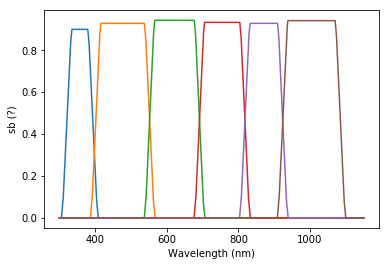

In [11]:
# Let's plot a few bandpass objects to make sure they look right
for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [12]:
for filtername, bp in zip(filterlist, bps):
    print(filtername, my_sed.calcMag(bp))

u -38.363286414
g -39.5932780266
r -39.5241955821
i -39.4106749041
z -39.3887605585
y -39.3510774412


In [13]:
# OK, that looks scary (because the sun only has an apparent mag of -27), but we never said 
#what distance the stars are at. So we can just add a constant to all the mags and it's fine.


Some good next steps:
* grab the narrow band filter throughputs from that survey, and figure out how to read them into bandpass objects - check
* Once we have all the filters and the stellar spectra, time to build a giant array! Each row would have star Teff, logg, metallicity, and then magnitudes in each LSST filter and narrowband filter. Can save the whole thing as a numpy zip file for easy reloading

# SPLUS Survey Narrowband Filters:

In [14]:
splus_filt_dir = os.path.join(cwd, 'splus_filter_curves/')

In [15]:
narrowbandfiltlist = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

splus_narrowbands = []

# Only problem with getting the splus survey narrowbands to fit into the Bandpass object was
# that I needed to specify a max and min wavelength for some reason. Once they were explicitly
# defined, however, it went pretty smoothly.

for filtername in narrowbandfiltlist:
    
    tempB2 = Bandpass(wavelen_min=3000, wavelen_max=9000)
    tempB2.readThroughput(splus_filt_dir+filtername+'.dat')
    splus_narrowbands.append(tempB2)

In [16]:
splus_narrowbands

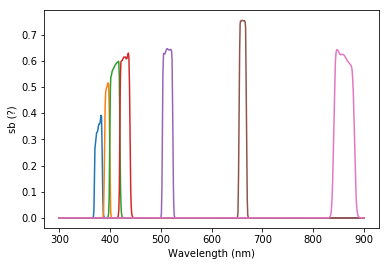

In [17]:
# plotting again to make sure they've come out right

for bp in splus_narrowbands:
    plt.plot(bp.wavelen/10, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [18]:
# judging by the plot, the magnitudes, and the magnitudes from your example, it looks right

for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
    print(filtername, my_sed.calcMag(bp))

F378 -37.2448971694
F395 -37.1659256375
F410 -37.0869358865
F430 -36.9983748142
F515 -36.6366569437
F660 -36.1228045279
F861 -35.5732719813


# Experimentation:

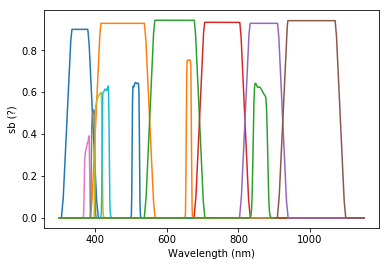

In [19]:
# Plotting it this way cuts off the last (~8500-9000 angstrom) filter. No idea why. --There was a zip, so it left off the last

for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
for nbp in splus_narrowbands:
    plt.plot(nbp.wavelen/10, nbp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

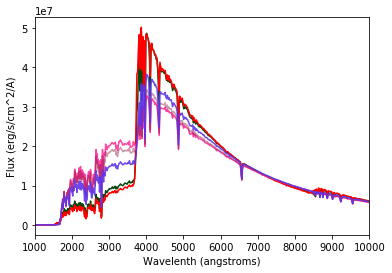

In [20]:
# plotting the same star at a few different values of log(g)

plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=1.0, color='xkcd:british racing green')
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=1.0, color='r')
plt.plot(spec_table['WAVELENGTH'], spec_table['g50'], alpha=1.0, color='xkcd:barbie pink')
plt.plot(spec_table['WAVELENGTH'], spec_table['g45'], alpha=0.4, color='xkcd:bordeaux')
plt.plot(spec_table['WAVELENGTH'], spec_table['g35'], alpha=0.9, color='xkcd:purpley blue')

plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000]);

In [21]:
plt.style.use('ggplot')

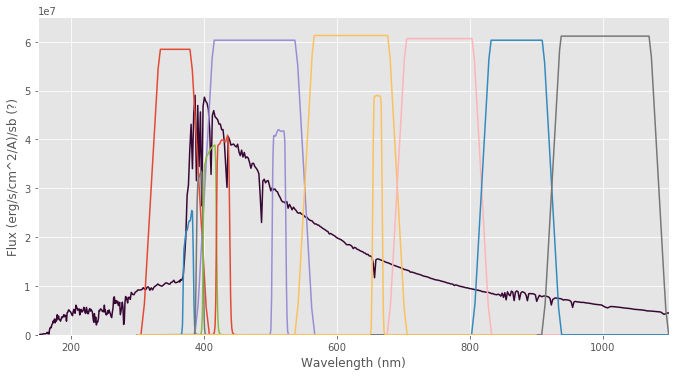

In [22]:
# y-axis is a mess here, but wanted one of the spectra and the filter bands overlaid

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          

ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux (erg/s/cm^2/A)/sb (?)")

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g15'], alpha=1.0, color='xkcd:eggplant')
for bp, nbp in zip(bps, splus_narrowbands):
    ax.plot(bp.wavelen, bp.sb*6.5*10**7, nbp.wavelen/10, nbp.sb*6.5*10**7);

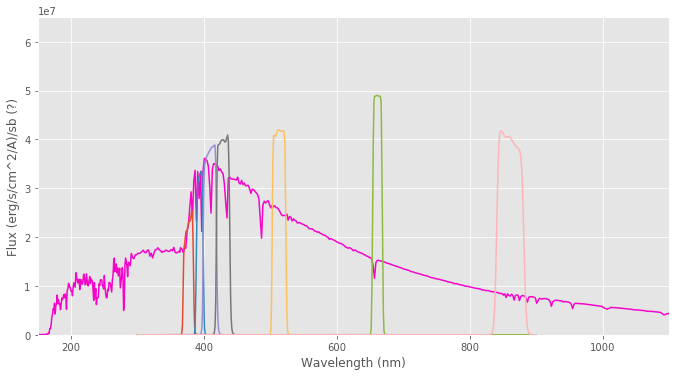

In [23]:
# now just for the narrowbands

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          


ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux (erg/s/cm^2/A)/sb (?)")

# just pretend that in the case of the filter bands, 6.5*10^7 is the same thing as 1

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g40'], alpha=1.0, color='xkcd:hot magenta')
for bp in splus_narrowbands:
    ax.plot(bp.wavelen/10, bp.sb*6.5*10**7);

# Putting the Bits Together:

In [24]:
# Success!

spectra_directory_keys = ['ckm05', 'ckm10', 'ckm15', 'ckm20', 'ckm25', 'ckp00', 'ckp02', 'ckp05']
gravity_keys = ['g00', 'g05', 'g10', 'g15', 'g20', 'g25', 'g30', 'g35', 'g40', 'g45', 'g50']
list_list =[]

for spectra_directory in spectra_directory_keys:
    directory = os.path.join(cwd, spectra_directory)
    filepath = glob.glob(os.path.join(directory,'*.fits'))
    
    for filename in filepath:
    
        hdul2 = fits.open(filename)
        header1 = hdul2[0].header.copy()
        spec_table1 = hdul2[1].data.copy()

        for grav in gravity_keys:
            
            # order will be filename, Teff, Fe/H, logg, various magnitudes
            star_properties = []
            #star_properties.append(os.path.basename(filename))
            teff = header1['TEFF']
            hella_metal = header1['LOG_Z']
            star_properties.append(np.float64(teff))
            star_properties.append(hella_metal)
            my_seds = Sed(wavelen=spec_table1['WAVELENGTH']/10, flambda=spec_table1[grav]*10)
            star_properties.append(np.float64(grav[1:]))

            for bp in splus_narrowbands:

                flux = my_seds.calcFlux(bp)

                if flux > 0:
                    nb_mag = my_seds.calcMag(bp)
                    star_properties.append(nb_mag)
                else:
                    star_properties.append(np.nan)
                    
            for bbp in bps:
                
                flux1 = my_seds.calcFlux(bbp)
                if flux1 > 0:
                    bb_mag = my_seds.calcMag(bbp)
                    star_properties.append(bb_mag)
            # Only add to the large arary if there were broad band fluxes
            if len(star_properties) > 4+len(splus_narrowbands) + 3:
                list_list.append(star_properties)
            
hdul2.close()

In [25]:
list_list[0:20]

[[10000.0,
  -0.5,
  20.0,
  -37.600781225738018,
  -37.518682012761786,
  -37.438457204041626,
  -37.347009095323173,
  -36.979227051274805,
  -36.458320481426355,
  -35.90274764416921,
  -40.059989441772672,
  -40.703819314921134,
  -40.45109888362424,
  -40.219424677455848,
  -40.111265919076899,
  -39.980302535214307],
 [10000.0,
  -0.5,
  25.0,
  -37.593295050157678,
  -37.511818132045462,
  -37.430435529226742,
  -37.340275324661008,
  -36.971905938436635,
  -36.451827546388103,
  -35.895202432318371,
  -40.018023938221617,
  -40.728301864506548,
  -40.453883712874443,
  -40.213569858701405,
  -40.103366774223659,
  -39.984702913368565],
 [10000.0,
  -0.5,
  30.0,
  -37.590382912463511,
  -37.509382017817387,
  -37.426883912009657,
  -37.338148659649235,
  -36.969035609546239,
  -36.450486476929726,
  -35.89254622229582,
  -39.977277958889346,
  -40.73557235999246,
  -40.454193337301533,
  -40.211323054353684,
  -40.091109039174995,
  -39.984237384511971],
 [10000.0,
  -0.5,
  35

In [26]:
# Finally. Looks to be in order. Let's save it as a numpy zip file so we can load it later
column_names = ['Teff', 'log_Z', 'gravity']
column_names.extend(narrowbandfiltlist)
column_names.extend(filterlist)
dtypes = [np.float64]*len(column_names)

In [27]:
# final arary 
temp_array = np.array(list_list)
model_atm_mags = np.zeros(temp_array.shape[0], dtype=list(zip(column_names, dtypes)))
# This is horrible and ugly, but I'm getting some weird dtype error.
for i,key in enumerate(model_atm_mags.dtype.names):
    model_atm_mags[key] += temp_array[:,i]

In [28]:
# Save the big handy array
np.savez('model_atm_mags.npz', model_atm_mags=model_atm_mags)

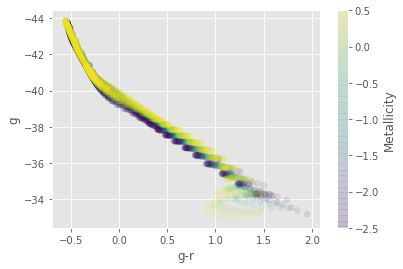

In [29]:
# Let's make a CMD
plt.scatter(model_atm_mags['g']-model_atm_mags['r'],model_atm_mags['g'],  c=model_atm_mags['log_Z'], alpha=.1)
cb = plt.colorbar()
cb.set_label('Metallicity')
plt.gca().invert_yaxis()
plt.xlabel('g-r')
plt.ylabel('g')

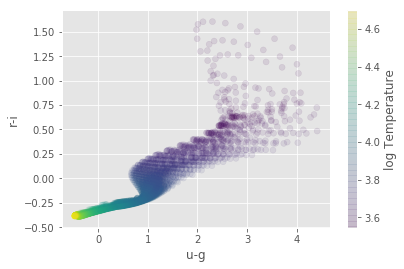

In [30]:

plt.scatter(model_atm_mags['u']-model_atm_mags['g'],model_atm_mags['r']-model_atm_mags['i'],
            c=np.log10(model_atm_mags['Teff']), alpha=.1)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.xlabel('u-g')
plt.ylabel('r-i')